# POC: When Normalizing embeddings is recommanded ?

In [1]:
from sentence_transformers import SentenceTransformer
import emoji
import pandas as pd
import numpy as np
import time
import re

import warnings
warnings.filterwarnings("ignore")


def clean_text(text: str) -> str:
    """
    Supprime les emojis et normalise les espaces dans une chaîne de caractères.

    INPUTS:
    text : str   Texte brut à nettoyer.

    OUTPUTS:
    str Texte nettoyé (sans emoji, avec espaces normalisés).
    """
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text

model_mini = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
model_multi = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device='cuda')


c:\Users\anass\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

This study uses a corpus collected from **X (formerly Twitter)** to analyze narrative trends at the intersection of **artificial intelligence** and **climate**. The goal is to surface dominant discourse axes as well as **weak signals** emerging from this dual theme.

**Collection.** Data were retrieved via the **official X API**, ensuring compliance with platform policies and preserving metadata integrity.

**Nature of the data.** The corpus is **real-world, multilingual, and noisy**, which makes it well-suited to illustrate how redundancy impacts NLP workflows.

**Minimal preprocessing.** We remove emojis, extra whitespace, and minor formatting artifacts; no additional normalization is applied.

**Basic statistics.**
- Total texts: **1,853**
- Exact duplicates: **639** (≈ **34%** of the corpus)
- Missing values: **none detected**

Exact duplicates are removed, and subsequent analyses operate on the **set of unique texts** only.


In [2]:
path = "data/importation-635-focus-AI.csv"
df = pd.read_csv(path, sep=";")
texts = df.sentences.apply(lambda x: clean_text(x)).tolist()

In [3]:
%timeit embeddings_multi_normalization = model_multi.encode(texts, device='cuda', normalize_embeddings=True, batch_size=64)
%timeit embeddings_multi = model_multi.encode(texts, device='cuda', batch_size=64)


embeddings_multi_normalization = model_multi.encode(texts, show_progress_bar=True, device='cuda', normalize_embeddings=True)
embeddings_multi = model_multi.encode(texts, show_progress_bar=True,device='cuda')

# Remove duplicate embeddings
embeddings_multi_normalization = np.unique(embeddings_multi_normalization, axis=0)
embeddings_multi = np.unique(embeddings_multi, axis=0)


1.47 s ± 4.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.48 s ± 6.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Batches: 100%|██████████| 58/58 [00:01<00:00, 38.56it/s]


In [ ]:
embeddings_multi.shape
model_mini

(1271, 384)

## Execution Time: Normalized vs. Non-Normalized Embeddings

We compare the encoding time of multilingual sentence embeddings using the `sentence-transformers` library (`model_multi`), both **with** and **without** L2-normalization.

**Observed timings (batch size ≈ 58):**
- With normalization: **1.39 seconds**
- Without normalization: **1.39 seconds**

**Comment:**  
The difference in runtime is negligible (~10 ms), confirming that `normalize_embeddings=True` dosen't introduce an **overhead**. This is expected, as the normalization step only involves a **per-row division by the L2 norm**, which is a lightweight vector operation well optimized on GPU.

In practice, enabling normalization is **strongly recommended**, as it:
- makes cosine similarity equivalent to a simple dot product,
- improves numerical stability and interpretability,
- aligns embedding usage with retrieval and clustering tasks.

We will explain each point in details


# Why Normalization Makes Cosine Similarity Equivalent to Dot Product

Let $x, y \in \mathbb{R}^d$ be two vectors.

The **cosine similarity** between them is defined as:

$$
\text{cosine\_sim}(x, y) = \frac{x \cdot y}{\|x\|_2 \cdot \|y\|_2}
$$

If $x$ and $y$ are **L2-normalized**, their L2-norm is equal to 1. That is, $\|x\|_2 = 1$ and $\|y\|_2 = 1$. The denominator in the formula becomes $1 \cdot 1 = 1$, and the expression simplifies to:

$$
\text{cosine\_sim}(x, y) = x \cdot y
$$

This leads to the key takeaway:
> **For unit vectors (L2-normalized vectors), cosine similarity is equivalent to the dot product.**

### Why Normalization Makes Cosine Similarity Equivalent to Dot Product

The **cosine similarity** between them is defined as:

$$
\text{cosine\_sim}(x, y) = \frac{x \cdot y}{\|x\|_2 \cdot \|y\|_2}
$$

If \( x \) and \( y \) are **L2-normalized**, then \( \|x\|_2 = 1 \) and \( \|y\|_2 = 1 \). The formula simplifies to:

$$
\text{cosine\_sim}(x, y) = x \cdot y
$$

So:

> **For unit vectors (L2-normalized vectors), cosine similarity is equivalent to the dot product.**


### Equivalence Between Cosine Distance and Euclidean Distance (for normalized vectors)

We now show that when \( x \) and \( y \) are unit vectors, the **Euclidean distance** and **cosine distance** are directly related.

Start from the squared Euclidean distance:

$$
\|x - y\|_2^2 = \|x\|^2 + \|y\|^2 - 2 x \cdot y
$$

If \( x \) and \( y \) are normalized, then \( \|x\|^2 = \|y\|^2 = 1 \), so:

$$
\|x - y\|_2^2 = 1 + 1 - 2 x \cdot y = 2(1 - x \cdot y)
$$

Recall that for normalized vectors, \( x \cdot y = \text{cosine\_similarity}(x, y) \). Therefore:

$$
\|x - y\|_2^2 = 2(1 - \text{cosine\_sim}(x, y))
$$

This gives the final equivalence:

$$
\text{cosine\_distance}(x, y) = 1 - \text{cosine\_sim}(x, y) = \frac{1}{2} \|x - y\|_2^2
$$


> This is why UMAP, HDBSCAN, k-NN, etc. can use **Euclidean distance** safely — **as long as the input vectors are normalized**

##  Test 1 with UMAP: Visualisation with UMAP in 2D, of normalized embedding using euc and cos distance, and no normalized embedding using cos distance:
We wait that we have 3 quasi identical shapes

In [21]:
import umap
import matplotlib.pyplot as plt


reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=-1, metric='cosine')
reducer2 = umap.UMAP(n_components=2, random_state=42, n_jobs=-1, metric='euclidean')

multi_normalization_umap = reducer.fit_transform(embeddings_multi_normalization)
multi_normalization_umap2 = reducer2.fit_transform(embeddings_multi_normalization)
multi_umap = reducer.fit_transform(embeddings_multi)

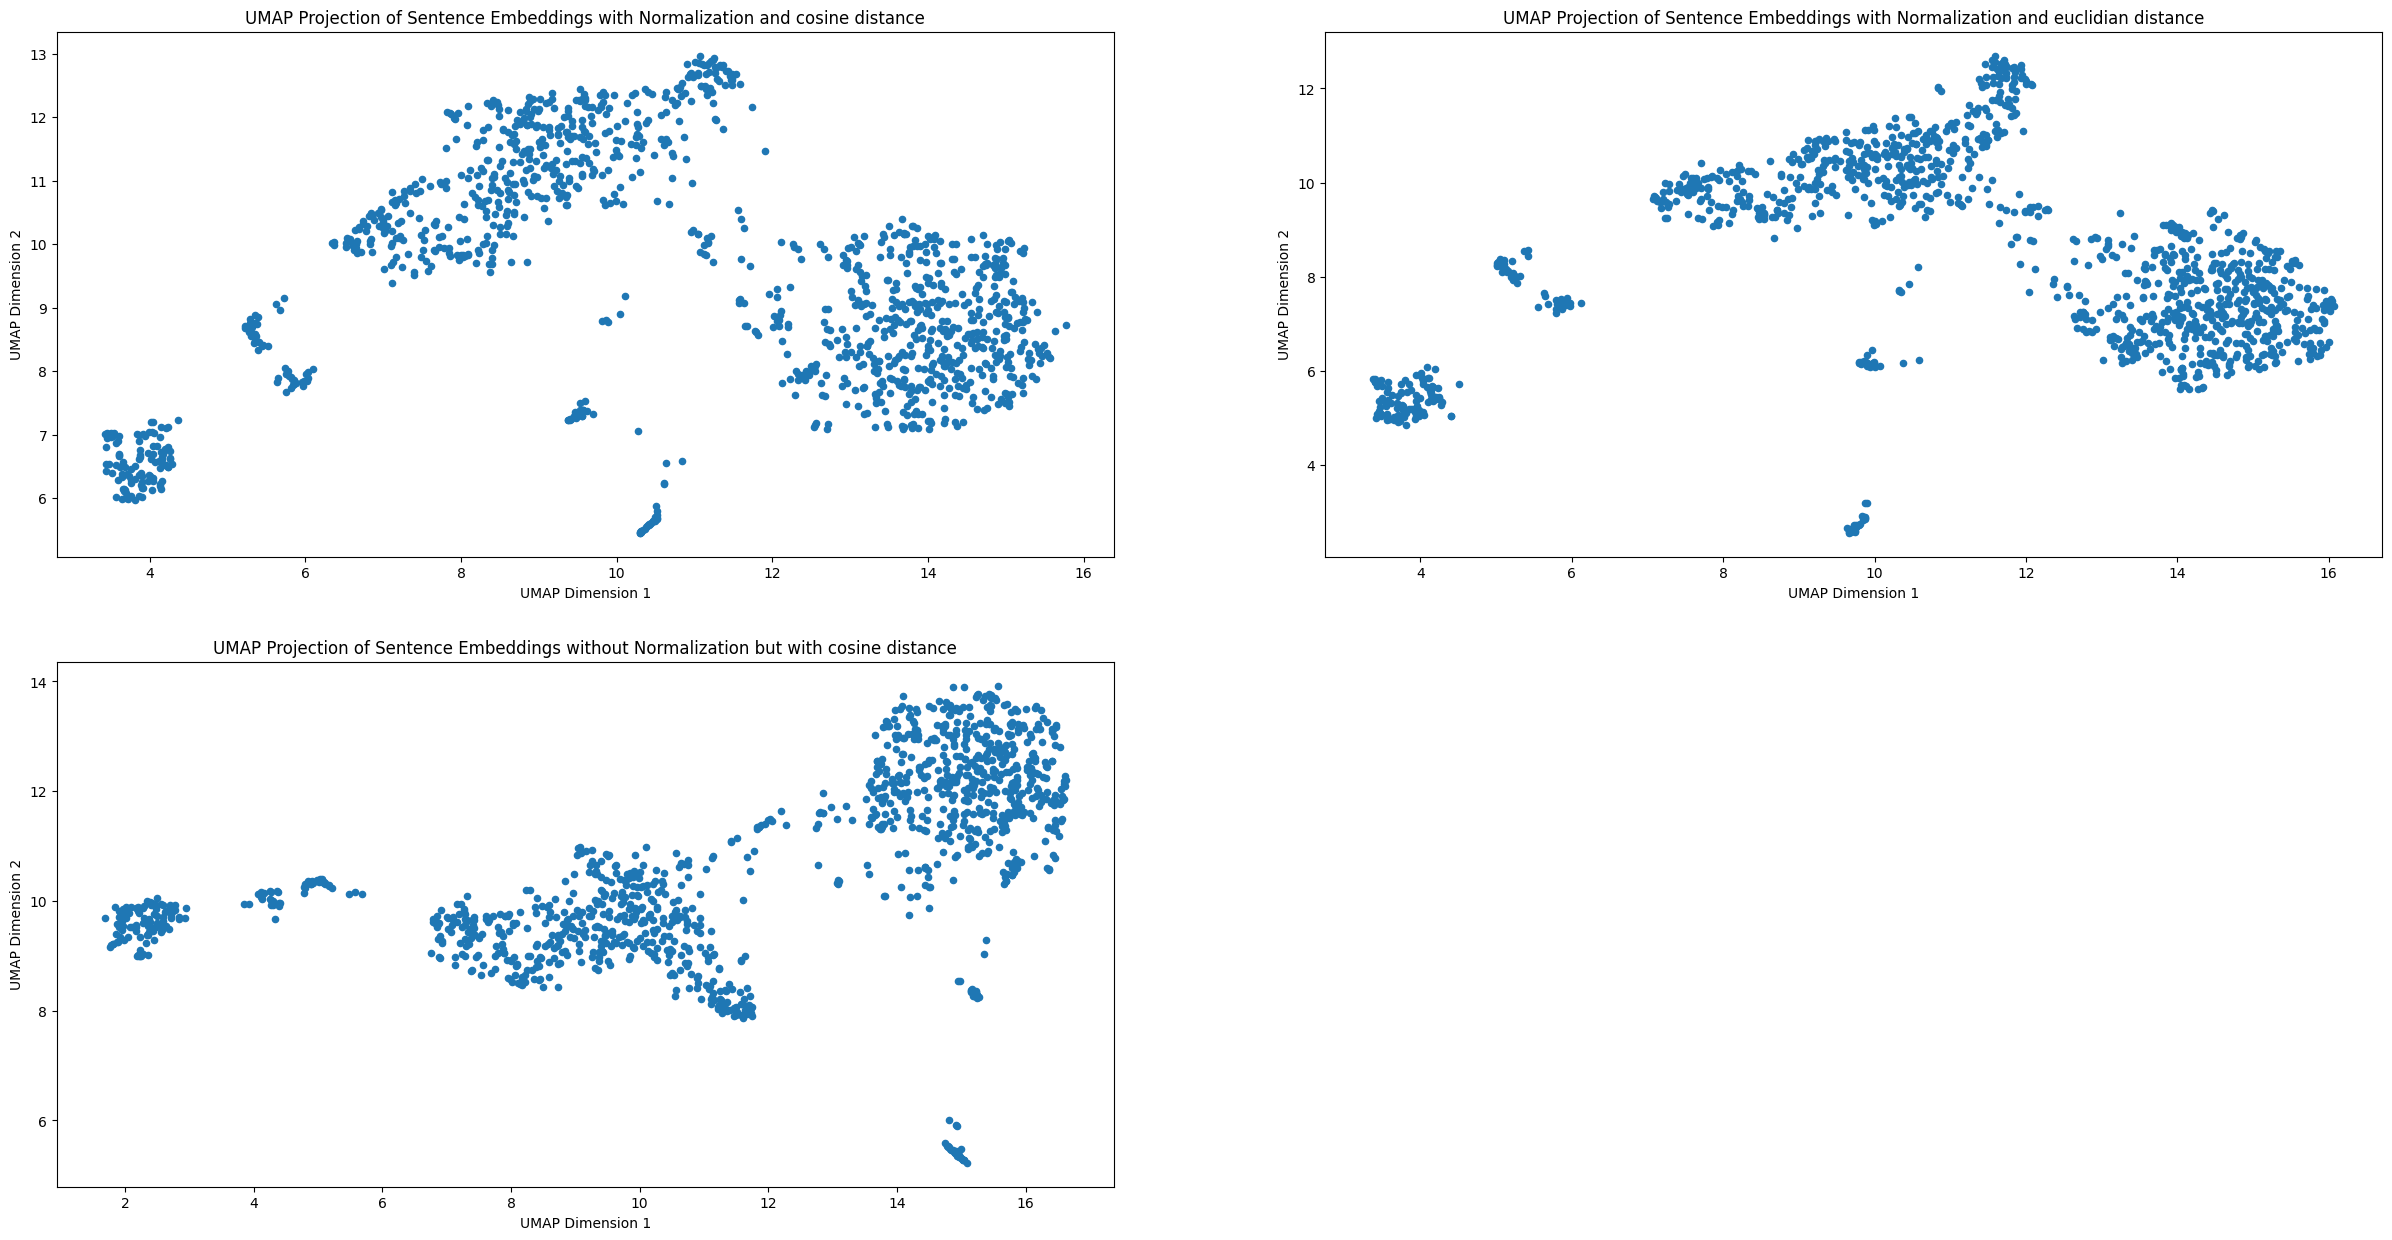

In [22]:
plt.figure(figsize=(30, 15))
plt.subplot(2, 2, 1)
plt.scatter(multi_normalization_umap[:, 0], multi_normalization_umap[:, 1], s=20, alpha=1)
plt.title("UMAP Projection of Sentence Embeddings with Normalization and cosine distance")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.subplot(2, 2, 2)


plt.subplot(2, 2, 2)
plt.scatter(multi_normalization_umap2[:, 0], multi_normalization_umap2[:, 1], s=20, alpha=1)
plt.title("UMAP Projection of Sentence Embeddings with Normalization and euclidian distance")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")


plt.subplot(2, 2, 3)
plt.scatter(multi_umap[:, 0], multi_umap[:, 1], s=20, alpha=1)
plt.title("UMAP Projection of Sentence Embeddings without Normalization but with cosine distance")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

plt.show()


After normalizing the sentence embeddings, we apply UMAP twice:

1. First with `metric="cosine"`  
2. Then with `metric="euclidean"`

Since the vectors are **unit vectors**, we know that:

$$
\text{cosine\_similarity}(x, y) = x \cdot y \quad \text{(dot product)}
$$

and:

$$
\|x - y\|_2^2 = 2(1 - x \cdot y)
\Rightarrow \text{cosine\_distance}(x, y) = \frac{1}{2} \|x - y\|_2^2
$$

Thus, **UMAP with cosine and Euclidean distances should produce nearly identical projections**, The small differences arise from numerical precision errors and the fact that UMAP’s optimization is stochastic and sensitive to initializations, even with equivalent distance geometry.


#### Observation

As expected, **both UMAP projections are almost identical**, validating the theory:

> **Once sentence embeddings are normalized, `metric='cosine'` and `metric='euclidean'` become interchangeable for UMAP and downstream clustering.**


## Test 2 with UMAP: What if we apply umap on not normalized data ?

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=-1, metric='cosine')
reducer2 = umap.UMAP(n_components=2, random_state=42, n_jobs=-1, metric='euclidean')

multi_umap1 = reducer.fit_transform(embeddings_multi)
multi_umap2 = reducer2.fit_transform(embeddings_multi)

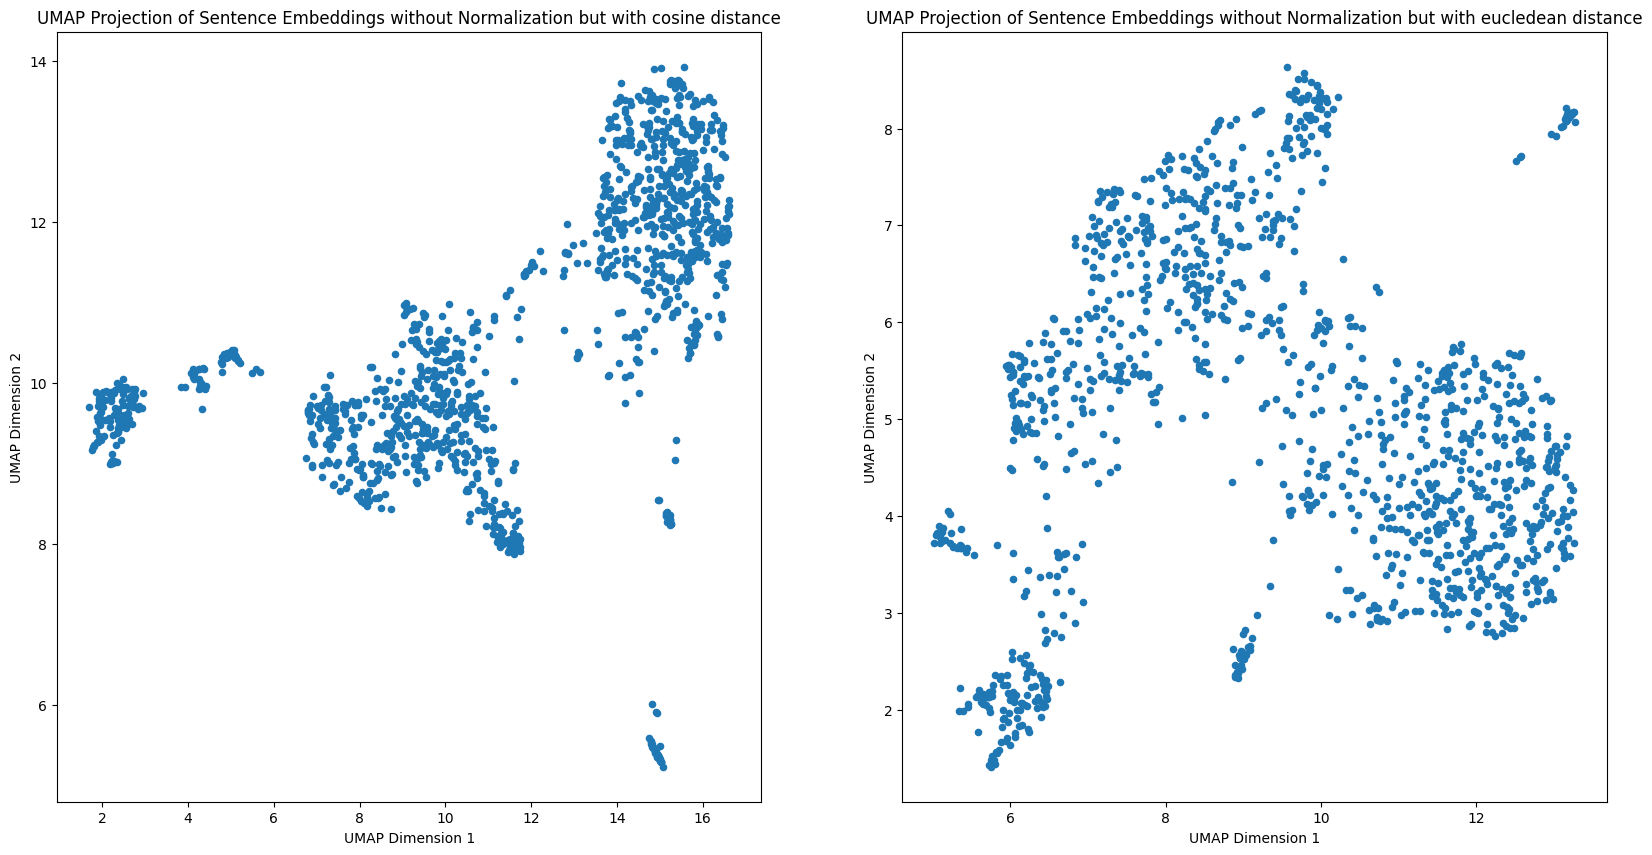

In [23]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(multi_umap1[:, 0], multi_umap1[:, 1], s=20, alpha=1)
plt.title("UMAP Projection of Sentence Embeddings without Normalization but with cosine distance")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.subplot(1, 2, 2)
plt.scatter(multi_umap2[:, 0], multi_umap2[:, 1], s=20, alpha=1)
plt.title("UMAP Projection of Sentence Embeddings without Normalization but with eucledean distance")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

plt.show()


## If a first vector isn't normalized and the second one is, we must have the same cos distance:

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
anass = model_multi.encode(["je m'appelle el basraoui anass"], device= "cuda", normalize_embeddings=True)  # Warm up the model
anass1 = model_multi.encode(["je m'appelle el basraoui anass"], device= "cuda", normalize_embeddings=False)  # Warm up the model

print("(We should have 1), The first vector's norm: ", (anass@anass.T).item())
print("(we shouldn't have 1), The second vector's norm: ", (anass1@anass1.T).item())


(We should have 1), The first vector's norm:  1.0
(we shouldn't have 1), The second vector's norm:  9.190729141235352


In [28]:
cosine_similarity(anass, anass1)

array([[1.]], dtype=float32)

## What about HDBSCAN ?

If we apply HDBSCAN after an UMAP, using euclidean distance isn't a choice, IT'S A MUST! 